# GeodesyNet vs MasconCube on Eros model (shape known)

In [182]:
# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchquad as tquad

from mascon_cube.constants import GROUND_TRUTH_DIR, OUTPUT_DIR, VAL_DATASETS_DIR
from mascon_cube.data.mascon_model import MasconModel
from mascon_cube.data.mesh import get_mesh, is_outside_torch, unpack_triangle_mesh
from mascon_cube.data.stokes import combine_stokes_coefficients, mascon2stokes
from mascon_cube.training import CubeTrainingConfig, ValidationConfig, training_loop
from mascon_cube.visualization import plot_mascon_cube, stokes_boxplot, stokes_heatmap, plot_asteroid
from mascon_cube.metrics import compute_acceleration, cosine_distance, norm_distance, relative_norm_distance
from mascon_cube.data.loading import load_dataset
from matplotlib import pyplot as plt
import pandas as pd
import gc
import os
from collections import deque

from mascon_cube import geodesynet
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
torch.manual_seed(42)
np.random.seed(42)

## Generate and visualize ground-truth

In [184]:
asteroid = "eros"

In [185]:
model = MasconModel(asteroid, device="cpu")
uniform_model = MasconModel(asteroid, device="cpu", uniform=True)

In [186]:
gt_stokes = mascon2stokes(model.coords, model.masses, r0=1, degree=7, order=7)
gt_stokes = combine_stokes_coefficients(gt_stokes[0], gt_stokes[1])

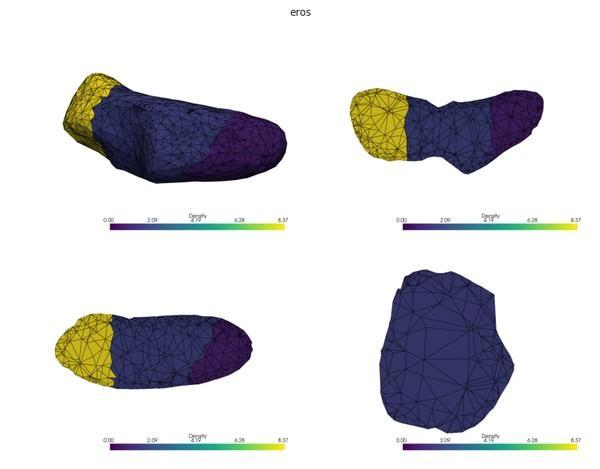

In [187]:
plot_asteroid(asteroid)
plt.show()

## Convert thethraedra model to cube model and compute stokes

In [188]:
cube_gt = model.to_cube(100)

In [189]:
cube_gt_stokes = mascon2stokes(cube_gt.coords, cube_gt.masses, r0=1, degree=7, order=7)
cube_gt_stokes = combine_stokes_coefficients(cube_gt_stokes[0], cube_gt_stokes[1])

## Plot Stokes coefficients of the cubified ground-truth

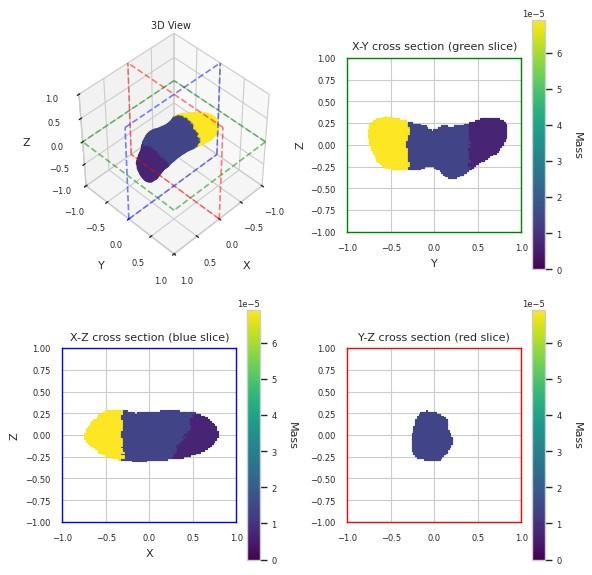

In [190]:
fig, range_ = plot_mascon_cube(cube_gt, return_range=True)
plt.show()

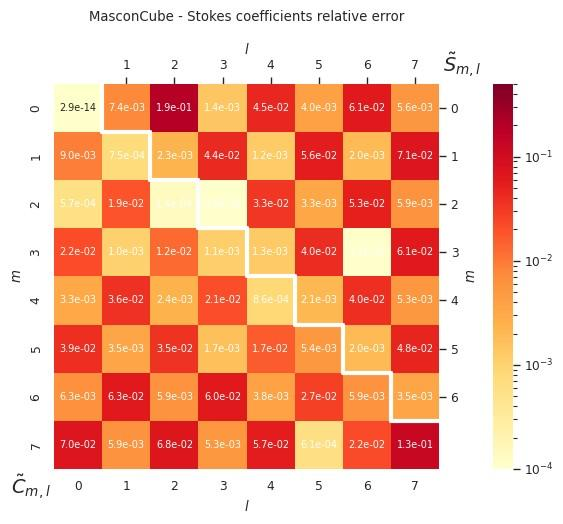

In [191]:
stokes_heatmap(cube_gt_stokes, gt_stokes, "MasconCube - Stokes coefficients relative error")
plt.show()

## Train a MasconCube

In [196]:
config = CubeTrainingConfig(
    asteroid=asteroid, cube_side=100, n_epochs=1000, n_epochs_before_resampling=10, activation_function="linear"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

val_dataset = torch.load(VAL_DATASETS_DIR / f"{asteroid}_1000_spherical_0_2.pt").to(device)
val_config = ValidationConfig(val_dataset=val_dataset, val_every_n_epochs=50)

# Train the cube
mascon_cube = training_loop(config, val_config, log_config=None, device=device, progressbar=True)

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


In [197]:
mascon_cube_stokes = mascon2stokes(mascon_cube.coords.detach(), mascon_cube.masses.detach(), r0=1, degree=7, order=7)
mascon_cube_stokes = combine_stokes_coefficients(mascon_cube_stokes[0], mascon_cube_stokes[1])

## Plot Stokes coefficients of the MasconCube

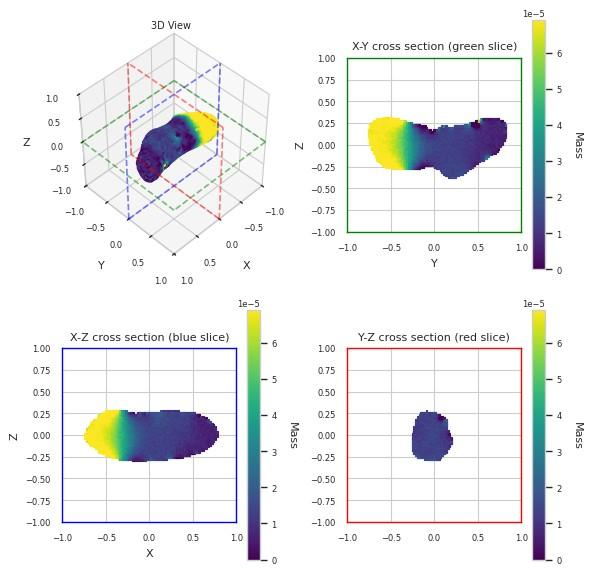

In [198]:
plot_mascon_cube(mascon_cube, range=range_)
plt.show()

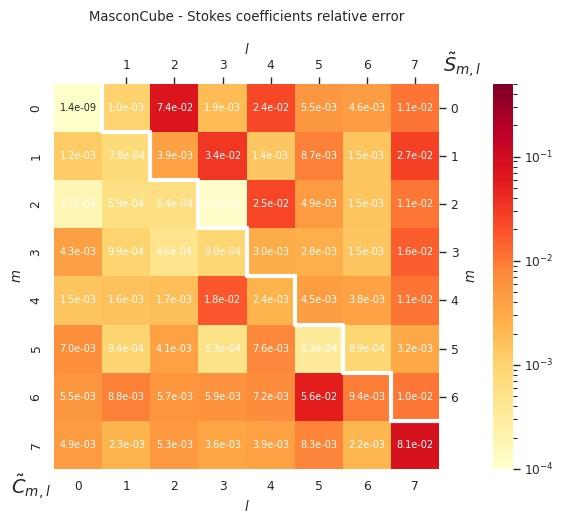

In [213]:
stokes_heatmap(mascon_cube_stokes, gt_stokes, "MasconCube - Stokes coefficients relative error")
plt.show()

## Train a GeodesyNet and computes stokes

In [199]:
do_training = False

In [200]:
torch.cuda.empty_cache()
gc.collect()
os.environ["TORCH_DEVICE"] = "cuda:0"
torch.manual_seed(42)
np.random.seed(42)

encoding = geodesynet.direct_encoding()
net = geodesynet.init_network(encoding, n_neurons=100, model_type="siren", activation=nn.Tanh()).to("cuda:0")
# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [201]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration.
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 30000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 100

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = geodesynet.normalized_L1_loss

# The numerical Integration method.
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = geodesynet.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = geodesynet.get_target_point_sampler(
    batch_size,
    limit_shape_to_asteroid=f"/home/pietrofanti/code/masconCube/data/3dmeshes/{asteroid.split('_')[0]}_lp.pk",
    method="spherical",
    bounds=[0.0, 1.0],
)
# Here we set the optimizer
learning_rate = 1e-6
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=200, min_lr=1e-6, verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = net.state_dict()

mascon_points = model.coords.to("cuda:0")
mascon_masses_nu = model.masses.to("cuda:0")
mascon_masses_u = uniform_model.masses.to("cuda:0")

/home/pietrofanti/miniforge3/envs/masconcube/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [202]:
if not do_training:
    net.load_state_dict(torch.load(OUTPUT_DIR / "geodesynet" / asteroid / "model.pt"))
    net = net.to("cuda:0")
    with open (OUTPUT_DIR / "geodesynet" / asteroid / "c.txt", "r") as f:
        c = f.readline()
    c = float(c)

In [203]:
if do_training:
    # TRAINING LOOP (differential training, use of any prior shape information)------------------------
    # This cell can be stopped and started again without loosing memory of the training nor its logs
    torch.cuda.empty_cache()
    # The main training loop
    for i in range(20000):
        # Each ten epochs we resample the target points
        if i % 10 == 0:
            target_points = targets_point_sampler()
            # We compute the labels whenever the target points are changed
            # These are the difference between a homogeneous and an inhomogenous ground truth
            labels_u = geodesynet.ACC_L(target_points, mascon_points, mascon_masses_u)
            labels_nu = geodesynet.ACC_L(target_points, mascon_points, mascon_masses_nu)
            labels = labels_nu - labels_u

        # We compute the values predicted by the neural density field
        predicted = mc_method(target_points, net, encoding, N=n_quadrature)

        # We learn the scaling constant (k in the paper)
        c = torch.sum(predicted * labels) / torch.sum(predicted * predicted)

        # We compute the loss (note that the contrastive loss needs a different shape for the labels)
        if loss_fn == geodesynet.contrastive_loss:
            loss = loss_fn(predicted, labels)
        else:
            loss = loss_fn(predicted.view(-1), labels.view(-1))

        # We store the model if it has the lowest fitness
        # (this is to avoid losing good results during a run that goes wild)
        if loss < best_loss:
            best_model_state_dict = net.state_dict()
            best_loss = loss
            print("New Best: ", loss.item())

        # Update the loss trend indicators
        weighted_average.append(loss.item())

        # Update the logs
        weighted_average_log.append(np.mean(weighted_average))
        loss_log.append(loss.item())
        n_inferences.append((n_quadrature * batch_size) // 100000)

        # Print every i iterations
        if i % 25 == 0:
            wa_out = np.mean(weighted_average)
            print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")

        # Zeroes the gradient (necessary because of things)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        # Perform a step in LR scheduler to update LR
        scheduler.step(loss.item())

In [204]:
if do_training:
    # Here we restore the learned parameters of the best model of the run
    for layer in net.state_dict():
        net.state_dict()[layer] = best_model_state_dict[layer]
    net = net.to("cuda:0")

In [205]:
if do_training:
    # First lets have a look at the training loss history
    plt.figure()
    abscissa = np.cumsum(n_inferences)
    plt.semilogy(abscissa, loss_log)
    plt.semilogy(abscissa, weighted_average_log)
    plt.xlabel("Thousands of model evaluations")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Weighted Average Loss"])

In [206]:
if do_training:
    # save state dict
    torch.save(net.state_dict(), OUTPUT_DIR / f"{asteroid}_geodesynet_state_dict.pt")

In [207]:
# We construct the vecotrized Legendre associated polynomials
P = geodesynet.legendre_factory_torch(n=16)
# Declare an integrator
quad = tquad.Trapezoid()

In [208]:
uniform_density = uniform_model.get_average_density()

mesh_vertices, mesh_triangles = get_mesh(asteroid)
triangles = unpack_triangle_mesh(mesh_vertices, mesh_triangles, "cuda")


def mass(x):
    result = net(x) * c
    mask = is_outside_torch(x, triangles)
    result[mask] = 0
    mask = torch.bitwise_not(mask)
    result[mask] += uniform_density
    return result

In [209]:
gc.collect()
torch.cuda.empty_cache()
# Compute the function integral
M = quad.integrate(mass, dim=3, N=300000, integration_domain=[[-1, 1], [-1, 1], [-1, 1]])
print(M)

tensor(0.9982, grad_fn=<SqueezeBackward0>)


/home/pietrofanti/miniforge3/envs/masconcube/lib/python3.12/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [210]:
stokesC_gann = np.zeros((8, 8))
for l in range(8):
    for m in range(8):
        if m > l:
            continue
        stokesC_gann[l][m] = quad.integrate(
            lambda x, l=l, m=m, P=P, net=mass, R0=1: geodesynet.Clm(x, net, l, m, R0, P),
            dim=3,
            N=310000,
            integration_domain=[[-1, 1], [-1, 1], [-1, 1]],
        )
        stokesC_gann[l][m] = stokesC_gann[l][m] / M * geodesynet.constant_factors(l, m)

In [211]:
stokesS_gann = np.zeros((8, 8))
for l in range(8):
    for m in range(8):
        if m > l:
            continue
        stokesS_gann[l][m] = quad.integrate(
            lambda x, l=l, m=m, P=P, net=mass, R0=1: geodesynet.Slm(x, net, l, m, R0, P),
            dim=3,
            N=300000,
            integration_domain=[[-1, 1], [-1, 1], [-1, 1]],
        )
        stokesS_gann[l][m] = stokesS_gann[l][m] / M * geodesynet.constant_factors(l, m)

In [212]:
geodesynet_stokes = combine_stokes_coefficients(stokesC_gann, stokesS_gann)

## GeodesyNet Stokes coefficients

Sampling points...: 2633it [01:15, 35.06it/s]                          


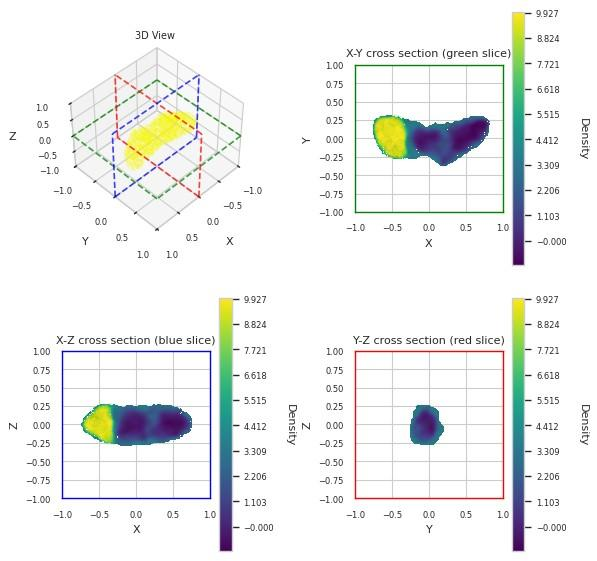

In [214]:
# Then overlaying a heatmap to the mascons
uniform_density = uniform_model.get_average_density()
torch.set_default_tensor_type(torch.cuda.FloatTensor)
geodesynet.plot_model_vs_mascon_contours(
    net,
    encoding,
    mascon_points,
    mascon_masses_nu,
    c=c,
    progressbar=True,
    crop_p=1e-8,
    N=2500,
    heatmap=True,
    add_shape_base_value=f"/home/pietrofanti/code/masconCube/data/3dmeshes/{asteroid.split('_')[0]}_lp.pk",
    add_const_density=uniform_density,
);

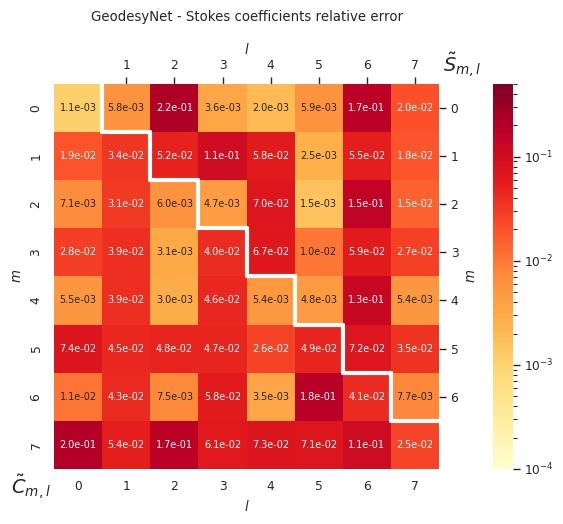

In [215]:
geodesynet_stokes = combine_stokes_coefficients(stokesC_gann, stokesS_gann)
stokes_heatmap(geodesynet_stokes, gt_stokes, "GeodesyNet - Stokes coefficients relative error")
plt.show()

## Final comparison

In [216]:
cube_error = np.abs(cube_gt_stokes - gt_stokes) / (np.abs(gt_stokes) + 1e-16)
mascon_cube_error = np.abs(mascon_cube_stokes - gt_stokes) / (np.abs(gt_stokes) + 1e-16)
geodesynet_error = np.abs(combine_stokes_coefficients(stokesC_gann, stokesS_gann) - gt_stokes) / (
    np.abs(gt_stokes) + 1e-16
)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/home/pietrofanti/code/masconCube/mascon_cube/visualization.py:272: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.plot([i + 1, i + 1], [i, i + 1], color="white", linewidth=3)


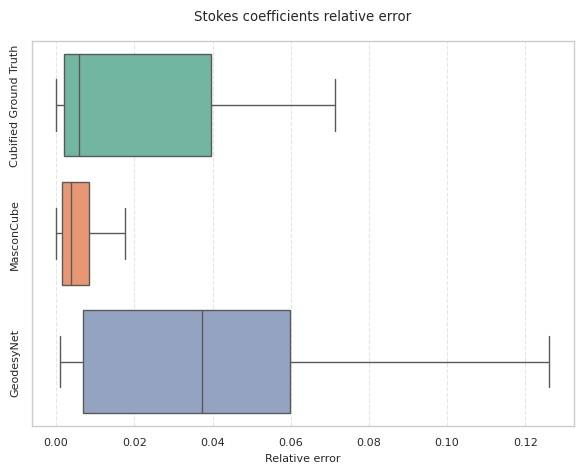

In [217]:
stokes_boxplot(
    [cube_error.flatten(), mascon_cube_error.flatten(), geodesynet_error.flatten()],
    labels=["Cubified Ground Truth", "MasconCube", "GeodesyNet"],
    title="Stokes coefficients relative error",
)
plt.show()

## Acceleration

We compute the acceleration over a fixed test set (different from the validation set) of 1000 points outside the asteroid sampled inside a sphere of radius 2

In [218]:
test_dataset = load_dataset(asteroid, test=True, device=device)
gt_acc = compute_acceleration(model.to(device), test_dataset)
cubified_gt_acc = compute_acceleration(cube_gt.to(device), test_dataset)
geodesynet_acc = compute_acceleration(net.to(device), test_dataset, batch_size=100, uniform_model=uniform_model.to(device), c=c)
cube_acc = compute_acceleration(mascon_cube.to(device), test_dataset)

In [219]:
d = {}
for method, acc in zip(("Cubified Ground Truth", "MasconCube", "GeodesyNet"), (cubified_gt_acc, cube_acc, geodesynet_acc)):
    d[method] = {}
    for distance_name, distance_fn in zip(("Cosine Distance", "Euclidean Norm Distance", "Relative Euclidean Norm Distance"), (cosine_distance, norm_distance, relative_norm_distance)):
        distance = distance_fn(acc, gt_acc)
        d[method][distance_name] = distance.mean().item()
pd.DataFrame(d)

,Cubified Ground Truth,MasconCube,GeodesyNet
Cosine Distance,5.215407e-08,9.585024e-07,0.000141
Euclidean Norm Distance,2.227743e-04,3.391246e-04,0.003274
Relative Euclidean Norm Distance,2.270587e-04,2.265655e-04,0.005742


## Training data

A **GeodesyNet** is trained for 10,000 epochs over a batch of 1,000 samples. The batch is updated every 10 epochs. So the **total number of training points is 1,000,000**.

A **MasconCube** is trained for 1,000 epochs over a batch of 1,000 samples. The batch is updated every 10 epochs. So the **total number of training points is 100,000**.